## Moku Example: Configuring FIR Filter Builder and plotting FRA Output

This example demonstrates how to configure the FIR Filter Builder and plot the frequency response using the Frequency Response Analyzer (FRA). This example is done in Multi-instrument mode so that only one Moku is needed. This example uses a Moku:Pro but can be run on any Moku device since it only utilizes two of the four Moku slots.

**(c) 2025 Liquid Instruments Pty. Ltd.**

In [2]:
import matplotlib.pyplot as plt

from moku.instruments import FIRFilterBox, FrequencyResponseAnalyzer, MultiInstrument

Connect to your Moku by using its IP address. In this configuration, it is important to first define the Multi-instrument object before setting the instruments in their respective slots. It is also important to first set the instruments into their slots before setting the connections of the instruments. 

In [3]:
m = MultiInstrument('192.168.2.200', force_connect=True, platform_id=4)

fir = m.set_instrument(slot=1, instrument=FIRFilterBox)
fra = m.set_instrument(slot=2, instrument=FrequencyResponseAnalyzer)
connections = [
    dict(source='Slot2OutA', destination='Slot1InA'),
    dict(source='Slot2OutB', destination='Slot1InB'),
    dict(source='Slot1OutA', destination='Slot2InA'),
    dict(source='Slot1OutB', destination='Slot2InB'),
]
m.set_connections(connections=connections)

print('Connected to Moku')

Connected to Moku


The code block below sets the parameters of the FIR filter. This will set the control matrix, input gain and offset, as well as enable the output so that the FRA is able to receive the response of the filter. In single instrument mode, the FIR filter and FRA have four inputs and four outputs. When in multi-instrument mode, they both only have two inputs and two outputs. 

In [4]:
fir.set_control_matrix(channel=1, input_gain1=1, input_gain2=0)
fir.set_input_gain(channel=1, gain=0)
fir.set_input_offset(channel=1, offset=0)
fir.enable_output(channel=1, signal=True, output=True, gain_range='0dB')
fir.set_output_gain(channel=1, gain=0)
fir.set_output_offset(channel=1, offset=0)

print('Successfully configured channel 1.')

Successfully configured channel 1.


Configure channel 2 of the FIR filter. 

In [5]:
fir.set_control_matrix(channel=2, input_gain1=1, input_gain2=0)
fir.set_input_gain(channel=2, gain=0)
fir.set_input_offset(channel=2, offset=0)
fir.enable_output(channel=2, signal=True, output=True, gain_range='0dB')
fir.set_output_gain(channel=2, gain=0)
fir.set_output_offset(channel=2, offset=0)

print('Successfully configured channel 2.')

Successfully configured channel 2.


Configure the filters. The supported filter shapes are lowpass, highpass, bandpass, and bandstop filters. The corner frequencies of the filters are expressed as a fraction of the sampling rate. For example, if the sampling rate is 39.06MHz and the corner value is 0.1, the corner frequency is 3.906MHz. 

In [6]:
fir.set_by_frequency(
    channel=1,
    sample_rate='39.06MHz',
    coefficient_count=201,
    shape='Lowpass',
    low_corner=0.1,
    window='Blackman',
)
fir.set_by_frequency(
    channel=2,
    sample_rate='39.06MHz',
    coefficient_count=201,
    shape='Highpass',
    high_corner=0.3,
    window='Blackman',
)

print('Successfully configured first and second filter.')

Successfully configured first and second filter.


Set the parameters for the FRA. The parameters to define are starting and ending frequency, length of the sweep, amplitude of the sweep signal, and the time to settle and average the response. 

In [7]:
f_start = 25e6
f_end = 10e3
sweep_length = 512
log_scale = True
amp_ch1 = 1
amp_ch2 = 1
averaging_time = 1e-6
settling_time = 1e-6
averaging_cycles = 1
settling_cycles = 1

The below block of code is to configure the FRA outputs and sweep parameters. To set the outputs, simply define the channel and amplitude of the signal. To set the sweep, set the parameters necessary to define the sweep.

In [8]:
fra.set_output(1, amp_ch1)
fra.set_output(2, amp_ch2)
fra.set_sweep(
    start_frequency=f_start,
    stop_frequency=f_end,
    num_points=sweep_length,
    averaging_time=averaging_time,
    settling_time=settling_time,
    averaging_cycles=averaging_cycles,
    settling_cycles=settling_cycles,
)
sweep = fra.start_sweep()
print(sweep['estimated_sweep_time'])

print('Configured FRA sweep successfully.')

0.013526380292257684
Configured FRA sweep successfully.


The below block of code will gather the data that the FRA has collected. The `fra.get_data` method will gather the data from the FRA as a data frame. Then, the data that is needed can be read by using `DataFrame['data_type']`.

The structure of the output of the `get_data()` function is:\
{"ch1":["magnitude":[],\
        "phase": [],\
        "frequency":[]],\
 "ch2":["magnitude":[],\
        "phase":[],\
        "frequency":[]],}
        

In [9]:
frame = fra.get_data(wait_complete=True, timeout=sweep['estimated_sweep_time'] + 60)
ch1Data = frame['ch1']
ch2Data = frame['ch2']

ch1MagDat = ch1Data['magnitude']
ch2MagDat = ch2Data['magnitude']

ch1PhaseData = ch1Data['phase']
ch2PhaseData = ch2Data['phase']

This will plot a single frame of FRA data.

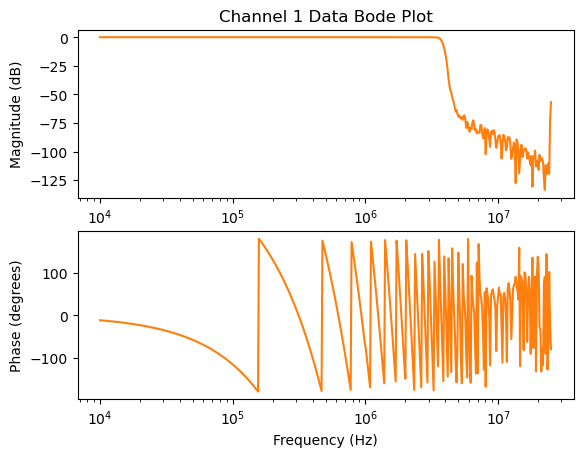

In [10]:
plt.subplot(211)
plt.title('Channel 1 Data Bode Plot')
plt.semilogx([])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(ch1Data['frequency'], ch1MagDat)
plt.subplot(212)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.semilogx([])
plt.plot(ch1Data['frequency'], ch1PhaseData)
plt.show()

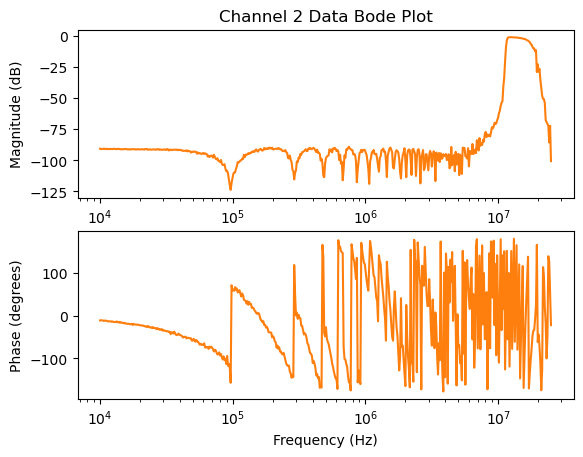

In [11]:
plt.subplot(211)
plt.title('Channel 2 Data Bode Plot')
plt.semilogx([])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(ch2Data['frequency'], ch2MagDat)
plt.subplot(212)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.semilogx([])
plt.plot(ch2Data['frequency'], ch2PhaseData)
plt.show()

Since there are only two available channels, it is necessary to reconfigure the first two channels.

In [12]:
fir.set_by_frequency(
    channel=1,
    sample_rate='39.06MHz',
    coefficient_count=201,
    shape='Bandpass',
    low_corner=0.1,
    high_corner=0.3,
    window='Blackman',
)
fir.set_by_frequency(
    channel=2,
    sample_rate='39.06MHz',
    coefficient_count=201,
    shape='Bandstop',
    low_corner=0.1,
    high_corner=0.3,
    window='Blackman',
)

print('Successfully reconfigured first and second filter.')

Successfully reconfigured first and second filter.


After reconfiguring the filters, it is necessary to call `fra.stop_sweep()` to clear the old FRA data and then call `fra.start_sweep()` again to acquire the new data. 

In [13]:
fra.stop_sweep()
sweep = fra.start_sweep()

print(sweep['estimated_sweep_time'])

print('Reconfigured FRA sweep successfully.')

0.013526380292257684
Reconfigured FRA sweep successfully.


In [14]:
newframe = fra.get_data(wait_complete=True, timeout=sweep['estimated_sweep_time'] + 60)
newch1Data = newframe['ch1']
newch2Data = newframe['ch2']

newch1MagDat = newch1Data['magnitude']
newch2MagDat = newch2Data['magnitude']

newch1PhaseData = newch1Data['phase']
newch2PhaseData = newch2Data['phase']

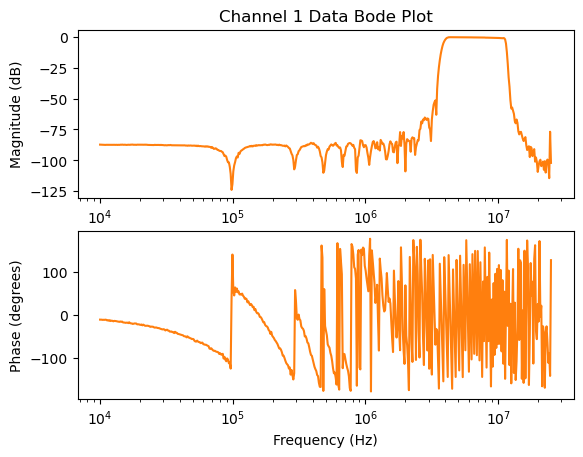

In [15]:
plt.subplot(211)
plt.title('Channel 1 Data Bode Plot')
plt.semilogx([])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(newch1Data['frequency'], newch1MagDat)
plt.subplot(212)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.semilogx([])
plt.plot(newch1Data['frequency'], newch1PhaseData)
plt.show()

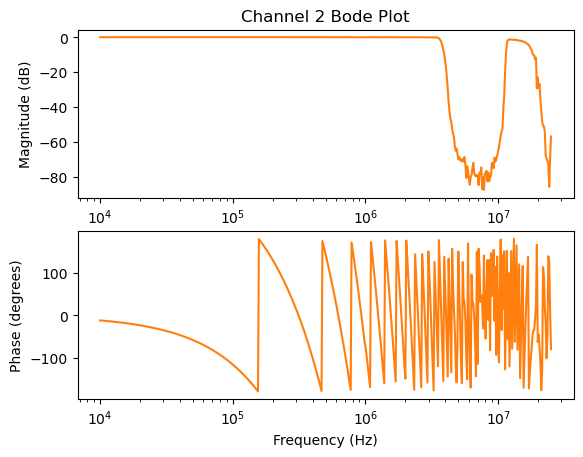

In [16]:
plt.subplot(211)
plt.title("Channel 2 Bode Plot")
plt.semilogx([])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(newch2Data['frequency'], newch2MagDat)
plt.subplot(212)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degrees)')
plt.semilogx([])
plt.plot(newch2Data['frequency'], newch2PhaseData)
plt.show()

Relinquish ownership to release network and hardware resources.

In [17]:
m.relinquish_ownership()